## Imports

In [3]:
import pandas as pd
import numpy as np
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


# preprocessing
from nltk.corpus import stopwords
from string import punctuation
from transformers import AutoTokenizer
from textstat import textstat
from nltk.util import ngrams


plt.style.use("fivethirtyeight")

In [62]:
torch.cuda.is_available()

False

In [4]:
prompts_train = pd.read_csv("data/prompts_train.csv")
prompts_test = pd.read_csv("data/prompts_test.csv")

summaries_train = pd.read_csv("data/summaries_train.csv")
summaries_test = pd.read_csv("data/summaries_test.csv")

sample_submission = pd.read_csv("data/sample_submission.csv")

In [5]:
sample_submission

,student_id,content,wording
0,000000ffffff,0.0,0.0
1,111111eeeeee,0.0,0.0
2,222222cccccc,0.0,0.0
3,333333dddddd,0.0,0.0


## Seed everything

In [64]:
def seed_everything(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)


seed_everything(42)

## Visualizations

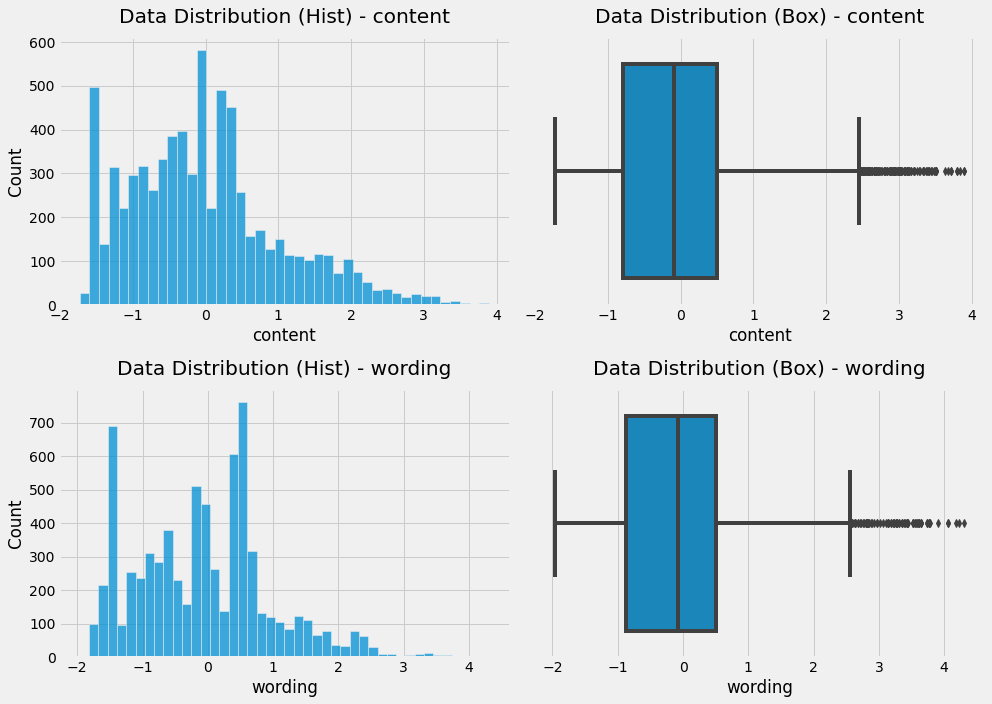

In [65]:
fig, ax = plt.subplots(2, 2, figsize=(14, 10))
sns.histplot(x="content", data=summaries_train, ax=ax[0][0])
sns.boxplot(x="content", data=summaries_train, ax=ax[0][1])
sns.histplot(x="wording", data=summaries_train, ax=ax[1][0])
sns.boxplot(x="wording", data=summaries_train, ax=ax[1][1])
ax[0][0].set_title(f"Data Distribution (Hist) - content", pad=15)
ax[0][1].set_title(f"Data Distribution (Box) - content", pad=15)
ax[1][0].set_title(f"Data Distribution (Hist) - wording", pad=15)
ax[1][1].set_title(f"Data Distribution (Box) - wording", pad=15)
fig.tight_layout()

## Data Preparation and Cleaning

In [66]:
summaries_train.shape, prompts_train.shape

((7165, 5), (4, 4))

In [67]:
summaries_train.head(5)

,student_id,prompt_id,text,content,wording
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757


In [68]:
prompts_train.head(4)

,prompt_id,prompt_question,prompt_title,prompt_text
0,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...
1,3b9047,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...
2,814d6b,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
3,ebad26,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an..."


In [69]:
summaries_train["text"][0]

'The third wave was an experimentto see how people reacted to a new one leader government. It gained popularity as people wanted to try new things. The students follow anything that is said and start turning on eachother to gain higher power. They had to stop the experement as too many people got to radical with it blindly following there leader'

<AxesSubplot: title={'center': 'Prompt ID Distribution'}, ylabel='prompt_id'>

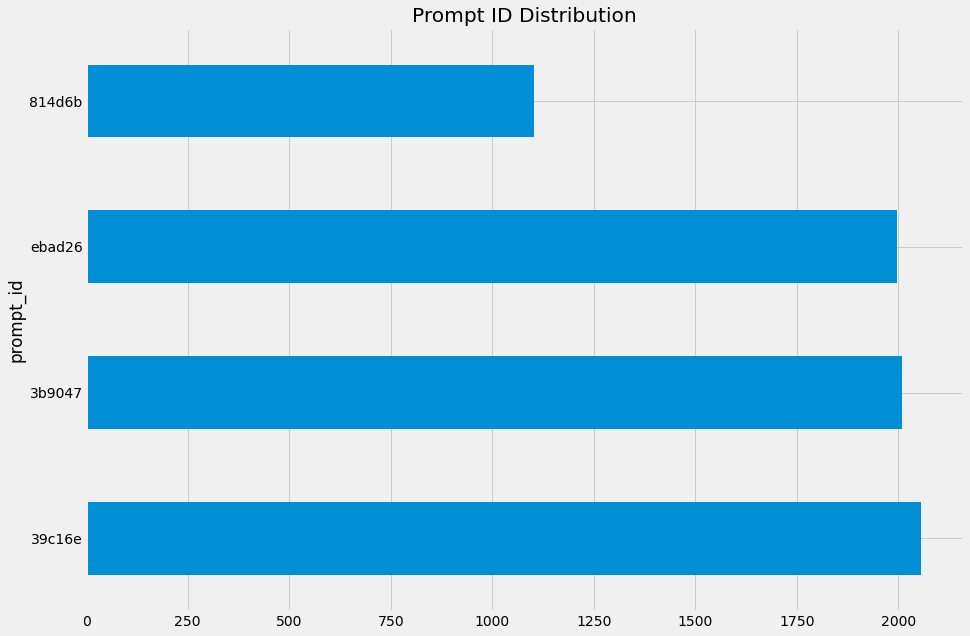

In [70]:
summaries_train["prompt_id"].value_counts().plot.barh(
    figsize=(14, 10), title="Prompt ID Distribution"
)

## Word Embeddings

## Data Augmentation

In [77]:
import nlpaug.augmenter.word as naw

In [78]:
aug = naw.SynonymAug(aug_src="wordnet")
augmented_text = aug.augment(train_data["text"][0])
augmented_text
print("Original:")
print(train_data["text"][0])
print("Augmented Text:")
print(augmented_text)

Original:
The third wave was an experimentto see how people reacted to a new one leader government. It gained popularity as people wanted to try new things. The students follow anything that is said and start turning on eachother to gain higher power. They had to stop the experement as too many people got to radical with it blindly following there leader
Augmented Text:
['The third undulation was an experimentto see how people reacted to a new one leader government. It gained popularity as people require to try new things. The students follow anything that be said and start turning on eachother to gain higher power. They sustain to stop over the experement as too many people got to radical with it blindly trace in that location leader']


In [79]:
augmented_text = []
for text in summaries_train["text"]:
    augmented_text.append(aug.augment(text))

augmented_text = pd.DataFrame(augmented_text, columns=["text"])
augmented_text["prompt_id"] = summaries_train["prompt_id"]
augmented_text["student_id"] = summaries_train["student_id"]
augmented_text["wording"] = summaries_train["wording"]
augmented_text["content"] = summaries_train["content"]

In [80]:
summaries_train = pd.concat([summaries_train, augmented_text], axis=0)

In [81]:
summaries_train

,student_id,prompt_id,text,content,wording
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757
...,...,...,...,...,...
7160,ff7c7e70df07,ebad26,They used all sorts of chemical substance conc...,0.205683,0.380538
7161,ffc34d056498,3b9047,The last classes are slave and fannie merritt ...,-0.308448,0.048171
7162,ffd1576d2e1b,3b9047,they sorta made people start work on the struc...,-1.408180,-0.493603
7163,ffe4a98093b2,39c16e,An ideal tragety has leash ingredient that mak...,-0.393310,0.627128


## Text preprocessing

### Merge Prompts and Summaries

In [82]:
merged_train = summaries_train.merge(prompts_train, on="prompt_id", how="inner")

In [83]:
merged_train

,student_id,prompt_id,text,content,wording,prompt_question,prompt_title,prompt_text
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
1,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
2,0095993991fe,814d6b,The third wave only started as an experiment w...,0.205683,0.380538,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
3,00c20c6ddd23,814d6b,The experimen was orginally about how even whe...,0.567975,0.969062,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
4,00d40ad10dc9,814d6b,The third wave developed so quickly due to the...,-0.910596,-0.081769,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
...,...,...,...,...,...,...,...,...
14325,fef3e85236e5,39c16e,"It hold to be made on a complex plot line, wit...",-0.981265,-1.548900,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...
14326,ff0f65eecf02,39c16e,Aristotle descirbes an idealistic tradgedy as ...,-0.511077,-1.589115,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...
14327,ff186473ea0a,39c16e,A tragedy should have a complex design not a w...,-0.834946,-0.593749,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...
14328,ff5e9e6068da,39c16e,Aristotle believed that the ideal tradegy shou...,-0.157460,-0.165811,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...


### Lowercasing / Tokenization / Stopwords / Punctuation

In [84]:
stopwords_list = set(stopwords.words("english"))
punctuation = list(punctuation)

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [85]:
def word_overlap_count(row):
    """intersection(prompt_text, text)"""

    def check_is_stop_word(word):
        return word in stopwords_list

    prompt_words = row["prompt_tokens"]
    summary_words = row["summary_tokens"]

    if stopwords_list:
        prompt_words = list(filter(check_is_stop_word, prompt_words))
        summary_words = list(filter(check_is_stop_word, summary_words))
    return len(set(prompt_words).intersection(set(summary_words)))

In [86]:
def clean_text(text):
    text = text.lower()
    text = tokenizer.tokenize(text, truncation=True, padding=True, max_length=1024)
    text = [word for word in text if word not in stopwords_list]
    text = [word for word in text if word not in punctuation]
    text = " ".join(text)
    return text


merged_train["clean_text"] = merged_train["text"].apply(clean_text)
merged_train["clean_prompt_text"] = merged_train["prompt_text"].apply(clean_text)

merged_train["summary_length"] = merged_train["text"].apply(
    lambda x: len(tokenizer.tokenize(x, truncation=True, padding=True, max_length=1024))
)

merged_train["summary_tokens"] = merged_train["text"].apply(
    lambda x: tokenizer.tokenize(x, truncation=True, padding=True, max_length=1024)
)

merged_train["prompt_length"] = merged_train["prompt_text"].apply(
    lambda x: len(tokenizer.tokenize(x, truncation=True, padding=True, max_length=1024))
)

merged_train["prompt_tokens"] = merged_train["prompt_text"].apply(
    lambda x: tokenizer.tokenize(x, truncation=True, padding=True, max_length=1024)
)

In [87]:
merged_train

,student_id,prompt_id,text,content,wording,prompt_question,prompt_title,prompt_text,clean_text,clean_prompt_text,summary_length,summary_tokens,prompt_length,prompt_tokens
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,third wave experiment ##to see people reacted ...,background third wave experiment took place cu...,69,"[the, third, wave, was, an, experiment, ##to, ...",671,"[background, the, third, wave, experiment, too..."
1,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,third wave developed rapidly students gen ##ui...,background third wave experiment took place cu...,261,"[the, third, wave, developed, rapidly, because...",671,"[background, the, third, wave, experiment, too..."
2,0095993991fe,814d6b,The third wave only started as an experiment w...,0.205683,0.380538,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,third wave started experiment within class slo...,background third wave experiment took place cu...,74,"[the, third, wave, only, started, as, an, expe...",671,"[background, the, third, wave, experiment, too..."
3,00c20c6ddd23,814d6b,The experimen was orginally about how even whe...,0.567975,0.969062,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,ex ##per ##ime ##n org ##inal ##ly even terrib...,background third wave experiment took place cu...,94,"[the, ex, ##per, ##ime, ##n, was, org, ##inal,...",671,"[background, the, third, wave, experiment, too..."
4,00d40ad10dc9,814d6b,The third wave developed so quickly due to the...,-0.910596,-0.081769,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,third wave developed quickly due students part...,background third wave experiment took place cu...,33,"[the, third, wave, developed, so, quickly, due...",671,"[background, the, third, wave, experiment, too..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14325,fef3e85236e5,39c16e,"It hold to be made on a complex plot line, wit...",-0.981265,-1.548900,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,hold made complex plot line plot makes hearing...,chapter 13 sequel already said must proceed co...,39,"[it, hold, to, be, made, on, a, complex, plot,...",765,"[chapter, 13, as, the, sequel, to, what, has, ..."
14326,ff0f65eecf02,39c16e,Aristotle descirbes an idealistic tradgedy as ...,-0.511077,-1.589115,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,aristotle des ##ci ##rb ##es ideal ##istic tr ...,chapter 13 sequel already said must proceed co...,47,"[aristotle, des, ##ci, ##rb, ##es, an, ideal, ...",765,"[chapter, 13, as, the, sequel, to, what, has, ..."
14327,ff186473ea0a,39c16e,A tragedy should have a complex design not a w...,-0.834946,-0.593749,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,tragedy complex design wide eyed one depend ##...,chapter 13 sequel already said must proceed co...,40,"[a, tragedy, should, have, a, complex, design,...",765,"[chapter, 13, as, the, sequel, to, what, has, ..."
14328,ff5e9e6068da,39c16e,Aristotle believed that the ideal tradegy shou...,-0.157460,-0.165811,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,aristotle believed ideal trade ##gy admit cat ...,chapter 13 sequel already said must proceed co...,63,"[aristotle, believed, that, the, ideal, trade,...",765,"[chapter, 13, as, the, sequel, to, what, has, ..."


## Feature Engineering

In [88]:
def ngram_co_occurrence(row, n: int) -> int:
    # Tokenize the original text and summary into words
    original_tokens = row["prompt_tokens"]
    summary_tokens = row["summary_tokens"]

    # Generate n-grams for the original text and summary
    original_ngrams = set(ngrams(original_tokens, n))
    summary_ngrams = set(ngrams(summary_tokens, n))

    # Calculate the number of common n-grams
    common_ngrams = original_ngrams.intersection(summary_ngrams)

    return len(common_ngrams)

In [89]:
from rouge import Rouge

rouge = Rouge()


def get_rouge_score(row):
    scores = rouge.get_scores(row["text"], row["prompt_text"])
    return scores[0]["rouge-1"]["f"]

In [90]:
# Add flesch reading ease for every text

# Score	Difficulty
# 90-100	Very Easy
# 80-89	Easy
# 70-79	Fairly Easy
# 60-69	Standard
# 50-59	Fairly Difficult
# 30-49	Difficult
# 0-29	Very Confusing

merged_train["flesch_reading_ease"] = merged_train["text"].apply(
    textstat.flesch_reading_ease
)
merged_train["difficult_words"] = merged_train["text"].apply(textstat.difficult_words)
merged_train["text_standard"] = merged_train["text"].apply(textstat.text_standard)
merged_train["comma_count"] = merged_train["text"].apply(lambda x: x.count(","))
merged_train["period_count"] = merged_train["text"].apply(lambda x: x.count("."))
merged_train["bigrams_overlap_count"] = merged_train.apply(
    ngram_co_occurrence, args=(2,), axis=1
)
merged_train["trigrams_overlap_count"] = merged_train.apply(
    ngram_co_occurrence, args=(3,), axis=1
)
merged_train["fourgrams_overlap_count"] = merged_train.apply(
    ngram_co_occurrence, args=(4,), axis=1
)
merged_train["automated_readability_index"] = merged_train["text"].apply(
    textstat.automated_readability_index
)
merged_train["coleman_liau_index"] = merged_train["text"].apply(
    textstat.coleman_liau_index
)
merged_train["linsear_write_formula"] = merged_train["text"].apply(
    textstat.linsear_write_formula
)
merged_train["gunning_fog"] = merged_train["text"].apply(textstat.gunning_fog)
merged_train["smog_index"] = merged_train["text"].apply(textstat.smog_index)
merged_train["sentiment"] = merged_train["text"].apply(textstat.text_standard)
merged_train["word_overlap_count"] = merged_train.apply(word_overlap_count, axis=1)
merged_train["rouge"] = merged_train.apply(get_rouge_score, axis=1)

In [91]:
merged_train

,student_id,prompt_id,text,content,wording,prompt_question,prompt_title,prompt_text,clean_text,clean_prompt_text,...,trigrams_overlap_count,fourgrams_overlap_count,automated_readability_index,coleman_liau_index,linsear_write_formula,gunning_fog,smog_index,sentiment,word_overlap_count,rouge
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,third wave experiment ##to see people reacted ...,background third wave experiment took place cu...,...,2,1,8.3,9.04,8.375000,9.40,10.7,7th and 8th grade,16,0.127168
1,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,third wave developed rapidly students gen ##ui...,background third wave experiment took place cu...,...,4,0,9.5,10.43,6.625000,9.15,10.1,9th and 10th grade,28,0.227907
2,0095993991fe,814d6b,The third wave only started as an experiment w...,0.205683,0.380538,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,third wave started experiment within class slo...,background third wave experiment took place cu...,...,11,6,7.0,8.63,6.200000,8.13,9.4,8th and 9th grade,15,0.168605
3,00c20c6ddd23,814d6b,The experimen was orginally about how even whe...,0.567975,0.969062,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,ex ##per ##ime ##n org ##inal ##ly even terrib...,background third wave experiment took place cu...,...,11,5,14.5,10.97,16.333333,14.33,14.1,14th and 15th grade,18,0.231638
4,00d40ad10dc9,814d6b,The third wave developed so quickly due to the...,-0.910596,-0.081769,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,third wave developed quickly due students part...,background third wave experiment took place cu...,...,1,0,6.1,7.24,6.750000,8.36,0.0,6th and 7th grade,9,0.093750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14325,fef3e85236e5,39c16e,"It hold to be made on a complex plot line, wit...",-0.981265,-1.548900,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,hold made complex plot line plot makes hearing...,chapter 13 sequel already said must proceed co...,...,2,0,16.9,9.41,19.000000,15.95,0.0,9th and 10th grade,11,0.109422
14326,ff0f65eecf02,39c16e,Aristotle descirbes an idealistic tradgedy as ...,-0.511077,-1.589115,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,aristotle des ##ci ##rb ##es ideal ##istic tr ...,chapter 13 sequel already said must proceed co...,...,0,0,20.5,15.33,20.500000,18.85,0.0,20th and 21st grade,10,0.091743
14327,ff186473ea0a,39c16e,A tragedy should have a complex design not a w...,-0.834946,-0.593749,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,tragedy complex design wide eyed one depend ##...,chapter 13 sequel already said must proceed co...,...,3,1,3.9,5.26,5.000000,5.70,6.4,4th and 5th grade,10,0.104294
14328,ff5e9e6068da,39c16e,Aristotle believed that the ideal tradegy shou...,-0.157460,-0.165811,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,aristotle believed ideal trade ##gy admit cat ...,chapter 13 sequel already said must proceed co...,...,8,4,11.6,11.89,10.500000,10.72,10.5,10th and 11th grade,9,0.118694


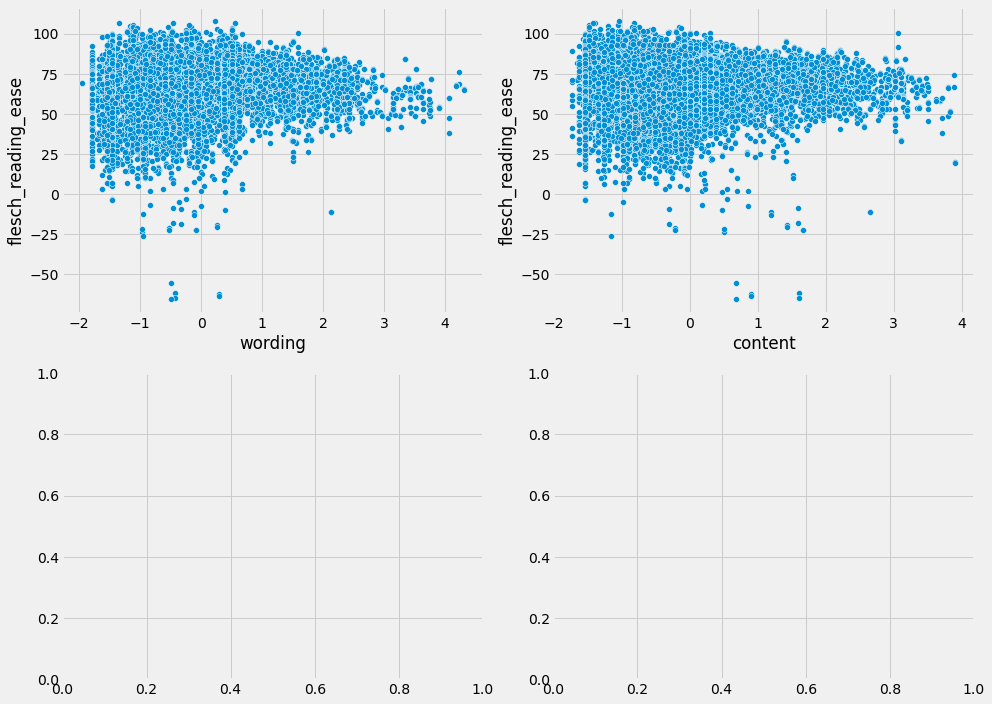

In [92]:
fig, ax = plt.subplots(2, 2, figsize=(14, 10))
sns.scatterplot(x="wording", y="flesch_reading_ease", data=merged_train, ax=ax[0][0])
sns.scatterplot(x="content", y="flesch_reading_ease", data=merged_train, ax=ax[0][1])
fig.tight_layout()

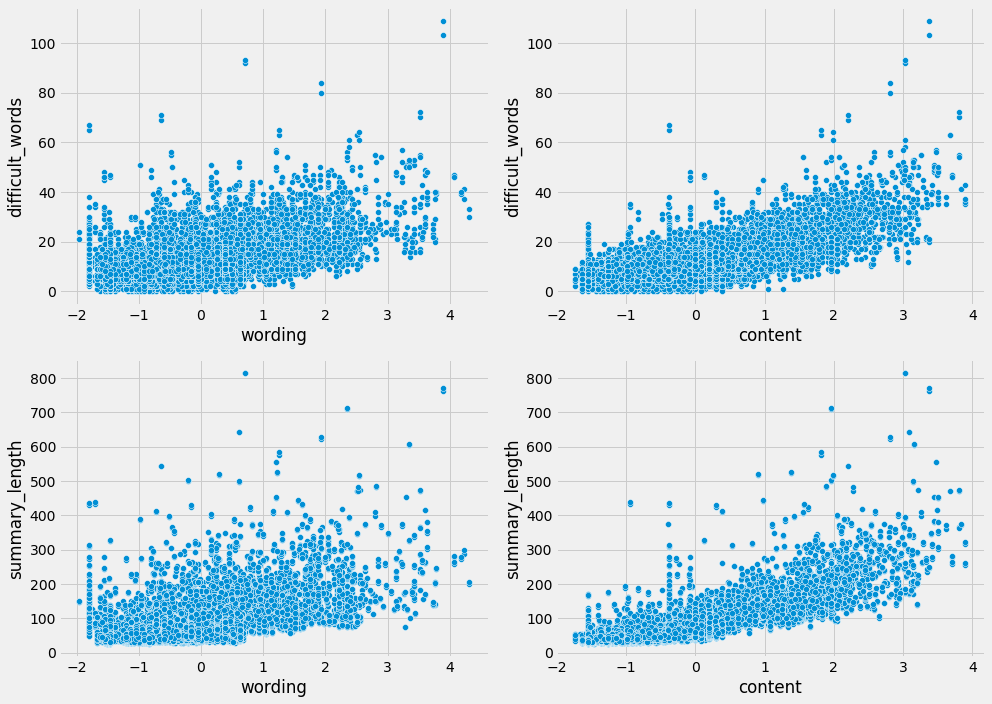

In [93]:
fig, ax = plt.subplots(2, 2, figsize=(14, 10))
sns.scatterplot(x="wording", y="difficult_words", data=merged_train, ax=ax[0][0])
sns.scatterplot(x="content", y="difficult_words", data=merged_train, ax=ax[0][1])
sns.scatterplot(x="wording", y="summary_length", data=merged_train, ax=ax[1][0])
sns.scatterplot(x="content", y="summary_length", data=merged_train, ax=ax[1][1])
fig.tight_layout()

In [94]:
def plot_corr_matrix(df):
    corr_matrix = df.corr()
    fig, ax = plt.subplots(figsize=(14, 10))
    sns.heatmap(corr_matrix, annot=True, ax=ax)
    ax.set_title("Correlation Matrix", pad=15)
    fig.tight_layout()

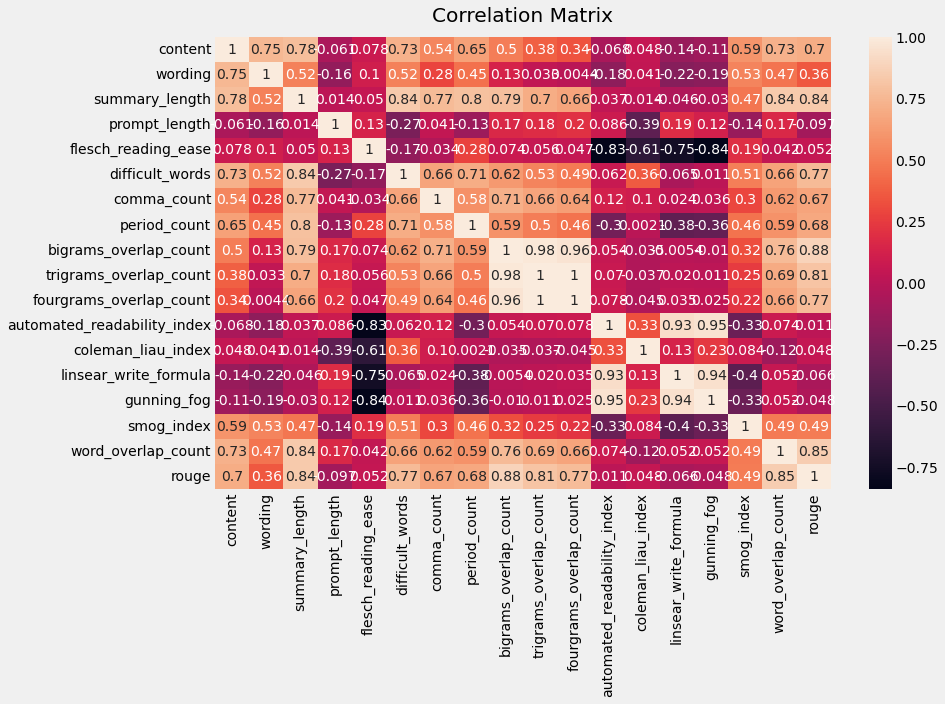

In [95]:
drop_columns = [
    "student_id",
    "prompt_id",
    "text",
    "prompt_question",
    "prompt_title",
    "prompt_text",
    "prompt_title",
    "clean_text",
    "clean_prompt_text",
    "summary_tokens",
    "prompt_tokens",
    "text_standard",
    "sentiment",
]
plot_corr_matrix(merged_train.drop(drop_columns, axis=1))

In [96]:
merged_train_train, merged_train_val = train_test_split(
    merged_train, test_size=0.2, random_state=42, stratify=merged_train["prompt_id"]
)

In [97]:
merged_train_train

,student_id,prompt_id,text,content,wording,prompt_question,prompt_title,prompt_text,clean_text,clean_prompt_text,...,trigrams_overlap_count,fourgrams_overlap_count,automated_readability_index,coleman_liau_index,linsear_write_formula,gunning_fog,smog_index,sentiment,word_overlap_count,rouge
11815,c280fd9cfc93,39c16e,"1. plot, a plot is what makes the story,charac...",-1.547163,-1.461245,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,1 plot plot makes story characters stuff build...,chapter 13 sequel already said must proceed co...,...,0,0,6.8,7.42,7.000000,7.03,0.0,6th and 7th grade,9,0.086420
7042,6ba535b08260,3b9047,At the top of the structure were the phara...,-0.536299,-0.674869,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...,top structure pharaoh viz ##ier pharaoh many d...,egyptian society structured like pyramid top g...,...,5,2,8.1,8.40,7.500000,7.33,0.0,7th and 8th grade,9,0.101493
10118,f3dc074fe0a0,3b9047,The ancient Egyptian system of government was ...,1.231350,0.194346,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...,ancient egyptian system government st ##rut ##...,egyptian society structured like pyramid top g...,...,33,27,11.9,11.31,10.500000,11.45,12.5,10th and 11th grade,21,0.237975
2643,389acd13610b,ebad26,They would either can the spoiled meat or they...,-0.910596,-0.081769,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an...",would either spoiled meat would chop su ##sa #...,one member trim ##ming beef ##nery another wor...,...,9,6,6.1,6.78,6.500000,7.03,0.0,6th and 7th grade,10,0.077803
9684,bd6de14c6aae,3b9047,How the different societal classes be involved...,-1.264214,-1.505073,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...,different societal classes involved ancient eg...,egyptian society structured like pyramid top g...,...,0,0,17.7,14.16,18.500000,13.76,0.0,14th and 15th grade,10,0.078078
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4332,1256d16a51d2,ebad26,The meat factory would use different stratagie...,0.574461,0.998748,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an...",meat factory would use different strata ##gies...,one member trim ##ming beef ##nery another wor...,...,37,33,11.3,7.20,13.250000,10.57,8.2,7th and 8th grade,22,0.185484
6797,4a6271d3e13a,3b9047,the middle class were mostly craftsman or phys...,-0.933630,-0.031987,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...,middle class mostly craftsman physicians small...,egyptian society structured like pyramid top g...,...,1,0,7.8,10.58,3.833333,3.72,3.1,3rd and 4th grade,4,0.067073
11770,bd6d596b2b66,39c16e,"In the story ""on tragedy"" the author known as ...",0.659323,0.419791,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,story tragedy author known aristotle described...,chapter 13 sequel already said must proceed co...,...,5,1,22.1,10.81,25.500000,20.13,0.0,10th and 11th grade,22,0.184874
13600,a1c6a6be118d,39c16e,An idealistic tragedy 3 elements are. Modifica...,-1.144934,-0.834495,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,ideal ##istic tragedy 3 elements modification ...,chapter 13 sequel already said must proceed co...,...,3,1,6.8,9.53,4.000000,9.67,9.5,9th and 10th grade,7,0.091743


In [98]:
import xgboost as xgb

In [99]:
def compute_mcrmse(eval_pred):
    """
    Calculates mean columnwise root mean squared error
    https://www.kaggle.com/competitions/commonlit-evaluate-student-summaries/overview/evaluation
    """
    preds, labels = eval_pred

    col_rmse = np.sqrt(np.mean((preds - labels) ** 2, axis=0))
    mcrmse = np.mean(col_rmse)

    return {
        "content_rmse": col_rmse[0],
        "wording_rmse": col_rmse[1],
        "mcrmse": mcrmse,
    }

In [100]:
TARGETS = ["content", "wording"]
FEATURES = [
    "flesch_reading_ease",
    "difficult_words",
    "summary_length",
    "comma_count",
    "bigrams_overlap_count",
    "trigrams_overlap_count",
    "automated_readability_index",
    "coleman_liau_index",
    "linsear_write_formula",
    "gunning_fog",
    "word_overlap_count",
    "rouge",
]


X_train = merged_train_train[FEATURES]
y_train = merged_train_train[TARGETS]

X_val = merged_train_val[FEATURES]
y_val = merged_train_val[TARGETS]

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((11464, 12), (11464, 2), (2866, 12), (2866, 2))

[11:55:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "lr", "wd" } are not used.

[0]	validation_0-rmse:0.92273


c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:0.52527
[127]	validation_0-rmse:0.52476


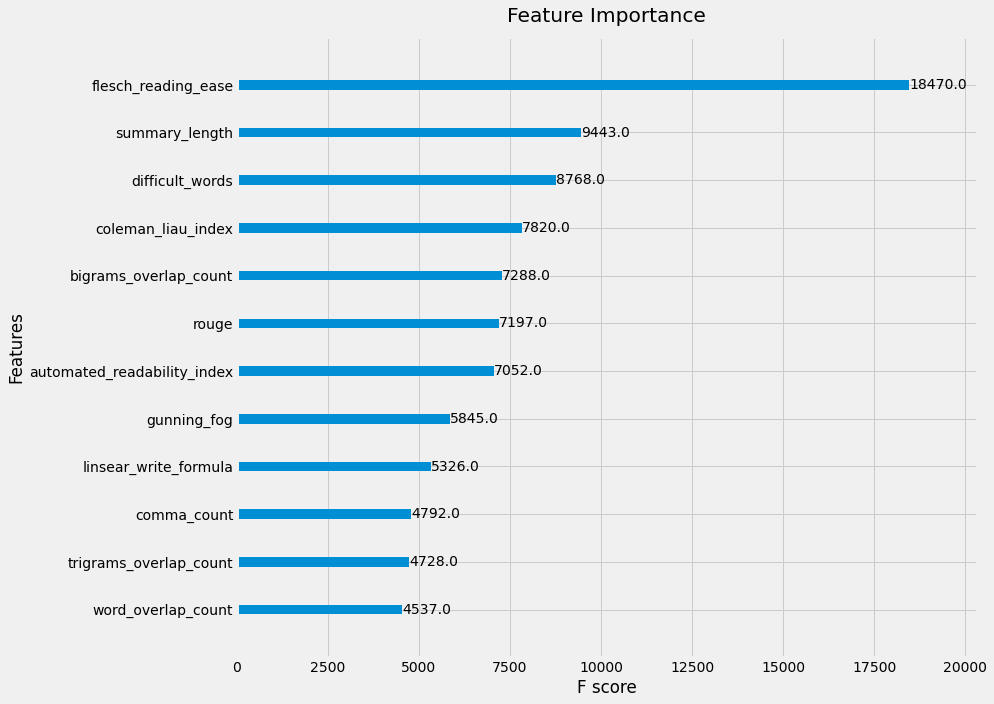

In [101]:
def CFG():
    config = {
        "lr": 0.01,
        "wd": 0.01,
        "max_depth": 10,
        "n_estimators": 1000,
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        "seed": 42,
        "tree_method": "gpu_hist",
        "gpu_id": 0,
    }
    return config


def run_xgb(X_train, y_train, X_val, y_val, config):
    model = xgb.XGBRegressor(**config)
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_val, y_val)],
        early_stopping_rounds=100,
        verbose=100,
    )
    return model


config = CFG()

model = run_xgb(X_train, y_train, X_val, y_val, config)


def plot_feature_importance(model):
    fig, ax = plt.subplots(figsize=(14, 10))
    xgb.plot_importance(model, ax=ax)
    ax.set_title("Feature Importance", pad=15)
    fig.tight_layout()


plot_feature_importance(model)

In [102]:
# tune hyperparameters of xgb model
from optuna.integration import XGBoostPruningCallback


def objective(trial):
    config = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 1e-1),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        "seed": 42,
        "tree_method": "gpu_hist",
        "gpu_id": 0,
    }

    pruning_callback = XGBoostPruningCallback(trial, "validation_0-rmse")

    model = xgb.XGBRegressor(**config)
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_val, y_val)],
        early_stopping_rounds=100,
        verbose=100,
        callbacks=[pruning_callback],
    )

    preds = model.predict(X_val)
    rmse = np.sqrt(np.mean((preds - y_val) ** 2))
    return rmse


import optuna

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

[I 2023-10-23 11:55:31,174] A new study created in memory with name: no-name-b7c6c159-984e-46a6-9525-dcd5c3393b74


[0]	validation_0-rmse:1.09466


c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:0.51301
[187]	validation_0-rmse:0.51029


[I 2023-10-23 11:55:34,137] Trial 0 finished with value: 0.510166204941141 and parameters: {'learning_rate': 0.09655710826002833, 'max_depth': 8, 'n_estimators': 188}. Best is trial 0 with value: 0.510166204941141.


[0]	validation_0-rmse:1.14689


c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:0.51674
[200]	validation_0-rmse:0.51171
[209]	validation_0-rmse:0.51152


[I 2023-10-23 11:55:37,557] Trial 1 finished with value: 0.511444828995921 and parameters: {'learning_rate': 0.03784826780467955, 'max_depth': 9, 'n_estimators': 210}. Best is trial 0 with value: 0.510166204941141.


[0]	validation_0-rmse:1.12470


c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:0.52014
[200]	validation_0-rmse:0.51602
[300]	validation_0-rmse:0.51435
[400]	validation_0-rmse:0.51293
[500]	validation_0-rmse:0.51230
[600]	validation_0-rmse:0.51150
[700]	validation_0-rmse:0.51118
[793]	validation_0-rmse:0.51121


[I 2023-10-23 11:55:44,576] Trial 2 finished with value: 0.5111284929027007 and parameters: {'learning_rate': 0.06319279452923142, 'max_depth': 7, 'n_estimators': 968}. Best is trial 0 with value: 0.510166204941141.


[0]	validation_0-rmse:1.12237


c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:0.50845
[200]	validation_0-rmse:0.50694
[300]	validation_0-rmse:0.50577
[400]	validation_0-rmse:0.50524
[500]	validation_0-rmse:0.50539
[502]	validation_0-rmse:0.50539


[I 2023-10-23 11:55:55,808] Trial 3 finished with value: 0.5052216251791216 and parameters: {'learning_rate': 0.06531122978866215, 'max_depth': 10, 'n_estimators': 674}. Best is trial 3 with value: 0.5052216251791216.


[0]	validation_0-rmse:1.15935


c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:0.59157
[200]	validation_0-rmse:0.55789
[300]	validation_0-rmse:0.54885
[400]	validation_0-rmse:0.54390
[456]	validation_0-rmse:0.54211


[I 2023-10-23 11:55:57,475] Trial 4 finished with value: 0.5421097867654903 and parameters: {'learning_rate': 0.027908773248670585, 'max_depth': 3, 'n_estimators': 457}. Best is trial 3 with value: 0.5052216251791216.


[0]	validation_0-rmse:1.14403


c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-10-23 11:55:57,534] Trial 5 pruned. Trial was pruned at iteration 0.


[0]	validation_0-rmse:1.15628


c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-10-23 11:55:57,602] Trial 6 pruned. Trial was pruned at iteration 0.
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-package

[0]	validation_0-rmse:1.10105
[100]	validation_0-rmse:0.51327


[I 2023-10-23 11:56:03,499] Trial 7 pruned. Trial was pruned at iteration 186.


[0]	validation_0-rmse:1.16533


c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-10-23 11:56:03,540] Trial 8 pruned. Trial was pruned at iteration 0.


[0]	validation_0-rmse:1.09704


c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:0.51539


[I 2023-10-23 11:56:05,060] Trial 9 pruned. Trial was pruned at iteration 120.


[0]	validation_0-rmse:1.18088


c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-10-23 11:56:05,149] Trial 10 pruned. Trial was pruned at iteration 0.


[0]	validation_0-rmse:1.11730


c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:0.51238
[200]	validation_0-rmse:0.51078
[300]	validation_0-rmse:0.50997
[400]	validation_0-rmse:0.50956
[419]	validation_0-rmse:0.50974


[I 2023-10-23 11:56:13,605] Trial 11 finished with value: 0.5094497375695243 and parameters: {'learning_rate': 0.07097414324922233, 'max_depth': 9, 'n_estimators': 420}. Best is trial 3 with value: 0.5052216251791216.
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-10-23 11:56:13,755] Trial 12 pruned. Trial was pruned at iteration 0.


[0]	validation_0-rmse:1.11544


c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:0.51365


[I 2023-10-23 11:56:16,369] Trial 13 pruned. Trial was pruned at iteration 131.


[0]	validation_0-rmse:1.11673


c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-10-23 11:56:16,628] Trial 14 pruned. Trial was pruned at iteration 21.
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packa

[0]	validation_0-rmse:1.10954
[100]	validation_0-rmse:0.51279
[200]	validation_0-rmse:0.51017
[300]	validation_0-rmse:0.50924
[400]	validation_0-rmse:0.50870
[479]	validation_0-rmse:0.50881


[I 2023-10-23 11:56:24,316] Trial 16 finished with value: 0.508659232856848 and parameters: {'learning_rate': 0.07972665452810591, 'max_depth': 8, 'n_estimators': 807}. Best is trial 3 with value: 0.5052216251791216.


[0]	validation_0-rmse:1.10788


c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-10-23 11:56:25,155] Trial 17 pruned. Trial was pruned at iteration 43.


[0]	validation_0-rmse:1.10690


c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-10-23 11:56:25,538] Trial 18 pruned. Trial was pruned at iteration 32.


[0]	validation_0-rmse:1.09311


c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-10-23 11:56:26,417] Trial 19 pruned. Trial was pruned at iteration 53.
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packa

[0]	validation_0-rmse:1.11597
[100]	validation_0-rmse:0.51263


[I 2023-10-23 11:56:28,866] Trial 21 pruned. Trial was pruned at iteration 107.
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-10-23 11:56:28,964] Trial 22 pruned. Trial was pruned at iteration 0.


[0]	validation_0-rmse:1.11035


c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-10-23 11:56:29,487] Trial 23 pruned. Trial was pruned at iteration 35.


[0]	validation_0-rmse:1.10343


c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-10-23 11:56:30,385] Trial 24 pruned. Trial was pruned at iteration 52.


[0]	validation_0-rmse:1.11991


c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:0.51143
[200]	validation_0-rmse:0.50903
[290]	validation_0-rmse:0.50809


[I 2023-10-23 11:56:38,387] Trial 25 finished with value: 0.5080880266853344 and parameters: {'learning_rate': 0.06808306269581638, 'max_depth': 10, 'n_estimators': 291}. Best is trial 3 with value: 0.5052216251791216.


[0]	validation_0-rmse:1.12033


c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-10-23 11:56:39,631] Trial 26 pruned. Trial was pruned at iteration 29.


[0]	validation_0-rmse:1.11208


c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:0.51174


[I 2023-10-23 11:56:43,449] Trial 27 pruned. Trial was pruned at iteration 131.
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-10-23 11:56:43,526] Trial 28 pruned. Trial was pruned at iteration 0.


[0]	validation_0-rmse:1.09733


c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-10-23 11:56:44,709] Trial 29 pruned. Trial was pruned at iteration 46.


[0]	validation_0-rmse:1.10801


c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-10-23 11:56:46,614] Trial 30 pruned. Trial was pruned at iteration 59.


[0]	validation_0-rmse:1.11745


c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-10-23 11:56:48,178] Trial 31 pruned. Trial was pruned at iteration 38.


[0]	validation_0-rmse:1.11947


c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:0.51042
[200]	validation_0-rmse:0.50952
[300]	validation_0-rmse:0.50814
[325]	validation_0-rmse:0.50802


[I 2023-10-23 11:56:59,247] Trial 32 finished with value: 0.5080165061025895 and parameters: {'learning_rate': 0.06857349593569344, 'max_depth': 10, 'n_estimators': 326}. Best is trial 3 with value: 0.5052216251791216.
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-10-23 11:56:59,443] Trial 33 pruned. Trial was pruned at iteration 0.
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` 

[0]	validation_0-rmse:1.13612


[I 2023-10-23 11:56:59,652] Trial 34 pruned. Trial was pruned at iteration 0.
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:1.11155


[I 2023-10-23 11:57:00,929] Trial 35 pruned. Trial was pruned at iteration 38.


[0]	validation_0-rmse:1.11963


c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-10-23 11:57:02,625] Trial 36 pruned. Trial was pruned at iteration 35.


[0]	validation_0-rmse:1.12765


c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-10-23 11:57:02,727] Trial 37 pruned. Trial was pruned at iteration 0.


[0]	validation_0-rmse:1.14281


c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-10-23 11:57:02,870] Trial 38 pruned. Trial was pruned at iteration 0.


[0]	validation_0-rmse:1.10107


c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-10-23 11:57:04,295] Trial 39 pruned. Trial was pruned at iteration 53.
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packa

[0]	validation_0-rmse:1.11672


c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-10-23 11:57:05,518] Trial 41 pruned. Trial was pruned at iteration 31.


[0]	validation_0-rmse:1.11372


c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-10-23 11:57:06,622] Trial 42 pruned. Trial was pruned at iteration 37.
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packa

[0]	validation_0-rmse:1.10667
[100]	validation_0-rmse:0.50929
[200]	validation_0-rmse:0.50852
[300]	validation_0-rmse:0.50775
[400]	validation_0-rmse:0.50746
[468]	validation_0-rmse:0.50730


[I 2023-10-23 11:57:22,402] Trial 45 finished with value: 0.5072876878004777 and parameters: {'learning_rate': 0.08300492025204143, 'max_depth': 10, 'n_estimators': 469}. Best is trial 3 with value: 0.5052216251791216.


[0]	validation_0-rmse:1.10746


c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:0.50977
[200]	validation_0-rmse:0.50776
[300]	validation_0-rmse:0.50613
[400]	validation_0-rmse:0.50620
[430]	validation_0-rmse:0.50612


[I 2023-10-23 11:57:35,516] Trial 46 finished with value: 0.5060507701261692 and parameters: {'learning_rate': 0.08211313437587442, 'max_depth': 10, 'n_estimators': 535}. Best is trial 3 with value: 0.5052216251791216.


[0]	validation_0-rmse:1.10636


c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:0.51058
[200]	validation_0-rmse:0.50801
[300]	validation_0-rmse:0.50710
[400]	validation_0-rmse:0.50690
[474]	validation_0-rmse:0.50661


[I 2023-10-23 11:57:49,818] Trial 47 finished with value: 0.506613572048723 and parameters: {'learning_rate': 0.08335926280240025, 'max_depth': 10, 'n_estimators': 475}. Best is trial 3 with value: 0.5052216251791216.


[0]	validation_0-rmse:1.09795


c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:0.50978
[200]	validation_0-rmse:0.50843
[300]	validation_0-rmse:0.50771
[400]	validation_0-rmse:0.50733
[500]	validation_0-rmse:0.50696
[528]	validation_0-rmse:0.50690


[I 2023-10-23 11:58:07,695] Trial 48 finished with value: 0.5068950883937926 and parameters: {'learning_rate': 0.09288515635541396, 'max_depth': 10, 'n_estimators': 529}. Best is trial 3 with value: 0.5052216251791216.


[0]	validation_0-rmse:1.10325


c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-10-23 11:58:08,039] Trial 49 pruned. Trial was pruned at iteration 18.


[0]	validation_0-rmse:1.09277


c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:0.51111


[I 2023-10-23 11:58:13,224] Trial 50 pruned. Trial was pruned at iteration 122.


[0]	validation_0-rmse:1.10435


c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-10-23 11:58:16,640] Trial 51 pruned. Trial was pruned at iteration 92.


[0]	validation_0-rmse:1.09948


c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:0.50930
[200]	validation_0-rmse:0.50801
[249]	validation_0-rmse:0.50763


[I 2023-10-23 11:58:24,585] Trial 52 finished with value: 0.5074520823700407 and parameters: {'learning_rate': 0.0911425708526652, 'max_depth': 10, 'n_estimators': 564}. Best is trial 3 with value: 0.5052216251791216.
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:1.09938
[100]	validation_0-rmse:0.50920
[200]	validation_0-rmse:0.50828
[300]	validation_0-rmse:0.50699
[400]	validation_0-rmse:0.50658
[500]	validation_0-rmse:0.50636
[543]	validation_0-rmse:0.50633


[I 2023-10-23 11:58:43,691] Trial 53 finished with value: 0.5063259017113725 and parameters: {'learning_rate': 0.09125960021087995, 'max_depth': 10, 'n_estimators': 544}. Best is trial 3 with value: 0.5052216251791216.
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:1.10690


c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-10-23 11:58:45,213] Trial 54 pruned. Trial was pruned at iteration 41.
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:1.10083
[100]	validation_0-rmse:0.50970


[I 2023-10-23 11:58:52,689] Trial 55 pruned. Trial was pruned at iteration 198.


[0]	validation_0-rmse:1.09479


c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-10-23 11:58:54,248] Trial 56 pruned. Trial was pruned at iteration 51.


[0]	validation_0-rmse:1.10536


c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-10-23 11:58:56,590] Trial 57 pruned. Trial was pruned at iteration 52.


[0]	validation_0-rmse:1.09702


c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-10-23 11:58:59,690] Trial 58 pruned. Trial was pruned at iteration 65.


[0]	validation_0-rmse:1.10248


c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-10-23 11:59:01,328] Trial 59 pruned. Trial was pruned at iteration 54.
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packa

[0]	validation_0-rmse:1.09198


[I 2023-10-23 11:59:04,296] Trial 60 pruned. Trial was pruned at iteration 60.


[0]	validation_0-rmse:1.09902


c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:0.50950
[200]	validation_0-rmse:0.50734
[300]	validation_0-rmse:0.50734


[I 2023-10-23 11:59:15,068] Trial 61 finished with value: 0.5072797656584692 and parameters: {'learning_rate': 0.09166858338208393, 'max_depth': 10, 'n_estimators': 572}. Best is trial 3 with value: 0.5052216251791216.
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:1.09867


[I 2023-10-23 11:59:17,752] Trial 62 pruned. Trial was pruned at iteration 61.


[0]	validation_0-rmse:1.10595


c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-10-23 11:59:20,135] Trial 63 pruned. Trial was pruned at iteration 57.


[0]	validation_0-rmse:1.10223


c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-10-23 11:59:21,404] Trial 64 pruned. Trial was pruned at iteration 39.
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packa

[0]	validation_0-rmse:1.09958


[I 2023-10-23 11:59:25,621] Trial 66 pruned. Trial was pruned at iteration 94.


[0]	validation_0-rmse:1.09483


c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-10-23 11:59:27,655] Trial 67 pruned. Trial was pruned at iteration 55.


[0]	validation_0-rmse:1.10735


c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-10-23 11:59:31,100] Trial 68 pruned. Trial was pruned at iteration 58.


[0]	validation_0-rmse:1.10450


c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-10-23 11:59:33,623] Trial 69 pruned. Trial was pruned at iteration 51.
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packa

[0]	validation_0-rmse:1.11098


[I 2023-10-23 11:59:33,842] Trial 70 pruned. Trial was pruned at iteration 0.


[0]	validation_0-rmse:1.09962


c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:0.50966
[200]	validation_0-rmse:0.50815


[I 2023-10-23 11:59:42,526] Trial 71 pruned. Trial was pruned at iteration 242.


[0]	validation_0-rmse:1.09891


c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-10-23 11:59:45,461] Trial 72 pruned. Trial was pruned at iteration 81.


[0]	validation_0-rmse:1.10328


c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-10-23 11:59:47,824] Trial 73 pruned. Trial was pruned at iteration 58.


[0]	validation_0-rmse:1.09489


c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-10-23 11:59:50,252] Trial 74 pruned. Trial was pruned at iteration 62.


[0]	validation_0-rmse:1.11464


c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-10-23 11:59:50,418] Trial 75 pruned. Trial was pruned at iteration 0.
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packag

[0]	validation_0-rmse:1.10092


c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-10-23 11:59:53,924] Trial 77 pruned. Trial was pruned at iteration 82.


[0]	validation_0-rmse:1.10145


c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-10-23 11:59:54,174] Trial 78 pruned. Trial was pruned at iteration 14.
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packa

[0]	validation_0-rmse:1.10655


c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-10-23 11:59:55,684] Trial 80 pruned. Trial was pruned at iteration 44.


[0]	validation_0-rmse:1.10240


c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-10-23 11:59:58,229] Trial 81 pruned. Trial was pruned at iteration 62.
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packa

[0]	validation_0-rmse:1.10471


c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-10-23 12:00:01,707] Trial 84 pruned. Trial was pruned at iteration 73.


[0]	validation_0-rmse:1.11777


c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-10-23 12:00:01,872] Trial 85 pruned. Trial was pruned at iteration 0.
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packag

[0]	validation_0-rmse:1.09844


c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-10-23 12:00:04,850] Trial 87 pruned. Trial was pruned at iteration 58.


[0]	validation_0-rmse:1.10163


c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-10-23 12:00:07,884] Trial 88 pruned. Trial was pruned at iteration 60.


[0]	validation_0-rmse:1.09331


c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-10-23 12:00:10,307] Trial 89 pruned. Trial was pruned at iteration 62.


[0]	validation_0-rmse:1.09664


c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:0.50874
[200]	validation_0-rmse:0.50752
[289]	validation_0-rmse:0.50742


[I 2023-10-23 12:00:21,384] Trial 90 finished with value: 0.5072445062121965 and parameters: {'learning_rate': 0.0943696288272622, 'max_depth': 10, 'n_estimators': 461}. Best is trial 3 with value: 0.5052216251791216.
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:1.09759
[100]	validation_0-rmse:0.51013


[I 2023-10-23 12:00:26,592] Trial 91 pruned. Trial was pruned at iteration 153.


[0]	validation_0-rmse:1.09585


c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-10-23 12:00:29,972] Trial 92 pruned. Trial was pruned at iteration 84.


[0]	validation_0-rmse:1.09192


c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-10-23 12:00:32,497] Trial 93 pruned. Trial was pruned at iteration 66.


[0]	validation_0-rmse:1.10456


c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:0.50984
[200]	validation_0-rmse:0.50737
[300]	validation_0-rmse:0.50636
[400]	validation_0-rmse:0.50591
[500]	validation_0-rmse:0.50581
[600]	validation_0-rmse:0.50566
[610]	validation_0-rmse:0.50563


[I 2023-10-23 12:00:52,714] Trial 94 finished with value: 0.5056255655282846 and parameters: {'learning_rate': 0.08539410371231644, 'max_depth': 10, 'n_estimators': 611}. Best is trial 3 with value: 0.5052216251791216.
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:1.09993
[100]	validation_0-rmse:0.50914


[I 2023-10-23 12:00:57,687] Trial 95 pruned. Trial was pruned at iteration 147.
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:1.10345


[I 2023-10-23 12:01:00,215] Trial 96 pruned. Trial was pruned at iteration 57.


[0]	validation_0-rmse:1.10673


c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-10-23 12:01:00,602] Trial 97 pruned. Trial was pruned at iteration 7.


[0]	validation_0-rmse:1.10063


c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:0.50962
[200]	validation_0-rmse:0.50821


[I 2023-10-23 12:01:08,095] Trial 98 pruned. Trial was pruned at iteration 232.


[0]	validation_0-rmse:1.10573


c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-10-23 12:01:10,647] Trial 99 pruned. Trial was pruned at iteration 54.


In [103]:
# results
study.best_params

{'learning_rate': 0.06531122978866215, 'max_depth': 10, 'n_estimators': 674}

In [104]:
# use best params
config = {
    "learning_rate": study.best_params["learning_rate"],
    "max_depth": study.best_params["max_depth"],
    "n_estimators": study.best_params["n_estimators"],
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "seed": 42,
    "tree_method": "gpu_hist",
    "gpu_id": 0,
}

model = run_xgb(X_train, y_train, X_val, y_val, config)

[0]	validation_0-rmse:1.12237


c:\Users\tharrmeehan\.conda\envs\DATA_SCIENCE_PERSONAL\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:0.50845
[200]	validation_0-rmse:0.50694
[300]	validation_0-rmse:0.50577
[400]	validation_0-rmse:0.50524
[500]	validation_0-rmse:0.50539
[501]	validation_0-rmse:0.50538


In [105]:
preds = model.predict(X_val)
eval_pred = (preds, y_val)
compute_mcrmse(eval_pred)

{'content_rmse': 0.4324134322128616,
 'wording_rmse': 0.5687850250658492,
 'mcrmse': 0.5005992286393554}

In [106]:
# catboost

from catboost import CatBoostRegressor


def run_catboost(X_train, y_train, X_val, y_val, config):
    model = CatBoostRegressor(**config)
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_val, y_val)],
        early_stopping_rounds=100,
        verbose=100,
    )
    return model


config = {
    "learning_rate": 0.01,
    "max_depth": 10,
    "n_estimators": 1000,
    "eval_metric": "MultiRMSE",
    "loss_function": "MultiRMSE",
    "random_seed": 42,
}

model2 = run_catboost(X_train, y_train, X_val, y_val, config)

preds = model2.predict(X_val)
eval_pred = (preds, y_val)
compute_mcrmse(eval_pred)

0:	learn: 1.4637518	test: 1.4543441	best: 1.4543441 (0)	total: 79.3ms	remaining: 1m 19s
100:	learn: 0.9560044	test: 0.9665448	best: 0.9665448 (100)	total: 7.95s	remaining: 1m 10s
200:	learn: 0.8089798	test: 0.8303388	best: 0.8303388 (200)	total: 15s	remaining: 59.8s
300:	learn: 0.7591013	test: 0.7890667	best: 0.7890667 (300)	total: 21.9s	remaining: 50.8s
400:	learn: 0.7344113	test: 0.7712274	best: 0.7712274 (400)	total: 28.4s	remaining: 42.4s
500:	learn: 0.7187021	test: 0.7614336	best: 0.7614336 (500)	total: 34.8s	remaining: 34.7s
600:	learn: 0.7061667	test: 0.7547683	best: 0.7547683 (600)	total: 41.1s	remaining: 27.3s
700:	learn: 0.6953833	test: 0.7496409	best: 0.7496409 (700)	total: 48.2s	remaining: 20.5s
800:	learn: 0.6853519	test: 0.7455570	best: 0.7455570 (800)	total: 55.4s	remaining: 13.8s
900:	learn: 0.6747829	test: 0.7418202	best: 0.7418202 (900)	total: 1m 2s	remaining: 6.89s
999:	learn: 0.6637892	test: 0.7380970	best: 0.7380970 (999)	total: 1m 9s	remaining: 0us

bestTest = 0.7

{'content_rmse': 0.4437291060292148,
 'wording_rmse': 0.5898233570793947,
 'mcrmse': 0.5167762315543047}

In [6]:
model

NameError: name 'model' is not defined